In [33]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper import series_to_supervised
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model, Model
from preprocess import water_postprocess
from performance import metrics_s1_t1

2024-01-28 14:10:25.789258: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Water Level

In [236]:
# ====== preprocessing parameters ======
n_hours = 72
k = 24 
masked_value = 1e-10
split_1 = 0.7
split_2 = 0.85

In [237]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = water_postprocess(n_hours, k, masked_value, split_1, split_2)


train_X_mask_rain_acc = train_X_mask[:, 0, 0]
val_X_mask_rain_acc = val_X_mask[:, 0, 0]
test_X_mask_rain_acc = test_X_mask[:, 0, 0]


percentile = 95
merged_array = np.concatenate((train_X_mask_rain_acc, val_X_mask_rain_acc, test_X_mask_rain_acc))
percentile_rain = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_rain)

# test
test_X_mask_extreme = test_X_mask[test_X_mask_rain_acc > percentile_rain]
test_ws_y_extreme = test_ws_y[test_X_mask_rain_acc > percentile_rain]
test_X_mask_normal = test_X_mask[test_X_mask_rain_acc <= percentile_rain]
test_ws_y_normal = test_ws_y[test_X_mask_rain_acc <= percentile_rain]

Index(['MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2',
       'GATE_S26_1', 'GATE_S26_2', 'PUMP_S25B', 'PUMP_S26', 'HWS_S25A',
       'HWS_S25B', 'HWS_S26', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26'],
      dtype='object')
95th Percentile of Daily Rain: 0.010711610503493287


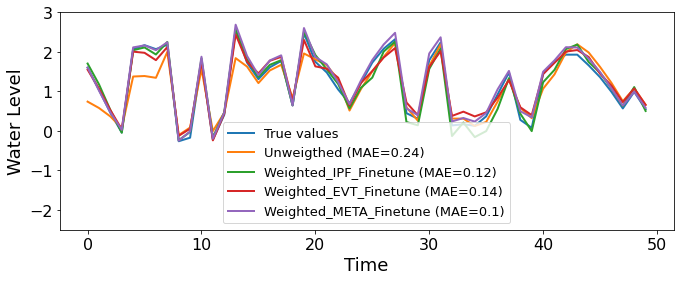

In [238]:
models = ['water_all_95.h5', 
          'water_all_weighted_IPF_95_ft.h5',
          'water_all_weighted_EVT_95_ft.h5', 
          'water_all_weighted_META_95_ft.h5'
         ]

labels = ['Unweigthed', 
          'Weighted_IPF_Finetune',
          'Weighted_EVT_Finetune', 
          'Weighted_META_Finetune'
         ]


plt.figure(figsize=(11, 4))
sample_id = 800
LINEWIDTH = 2
TICKSIZE = 16
FONTSIE = 18
LEGEND = 13

for i in range(len(models)):
    model_path = '../saved_models_mlp/' + models[i]
    #print('model:', model_path)
    saved_model = load_model(model_path) 
    yhat_extreme = saved_model.predict(test_X_mask_extreme)
    inv_yhat_extreme = ws_scaler.inverse_transform(yhat_extreme)
    inv_yhat_extreme = inv_yhat_extreme.reshape(-1, 24, 4)
    inv_y_extreme = ws_scaler.inverse_transform(test_ws_y_extreme)
    inv_y_extreme = inv_y_extreme.reshape(-1, 24, 4)

    #print(inv_yhat_extreme.shape, inv_y_extreme.shape,  '\n')
    sample_inv_yhat_extreme = inv_yhat_extreme[:50, 0, -1]
    sample_inv_y_extreme = inv_y_extreme[:50, 0, -1]
#     sample_inv_yhat_extreme = inv_yhat_extreme[sample_id, :, 0]
#     sample_inv_y_extreme = inv_y_extreme[sample_id, :, 0]
    
    if i == 0:
        plt.plot(sample_inv_y_extreme, linewidth=LINEWIDTH, label='True values')
    plt.plot(sample_inv_yhat_extreme, linewidth=LINEWIDTH, label=labels[i]+' (MAE={})'.format(float("{:.2f}".format(mae(sample_inv_yhat_extreme,sample_inv_y_extreme)))))
    plt.xticks(fontsize=TICKSIZE)
    plt.yticks(fontsize=TICKSIZE)
    plt.xlabel('Time', fontsize=FONTSIE)
    plt.ylabel('Water Level', fontsize=FONTSIE)
    plt.ylim(-2.5, 3)
    plt.legend(fontsize=LEGEND, loc='best')
    plt.savefig('figures/water_vis.jpg', bbox_inches='tight')
#     plt.show()

### Electricity price

In [228]:
dataset = pd.read_csv('../data/energy_weather.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
# data


values = data.values
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


train_X_pm = train_X[:, 0, feature_idx]
val_X_pm = val_X[:, 0, feature_idx]
test_X_pm = test_X[:, 0, feature_idx]


percentile = 95
merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))
percentile_pm = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)


test_X_extreme = test_X[test_X_pm > percentile_pm]
test_y_extreme = test_y[test_X_pm > percentile_pm]

test_X_normal = test_X[test_X_pm <= percentile_pm]
test_y_normal = test_y[test_X_pm <= percentile_pm]

95th Percentile of Daily Rain: 0.7037105569454176


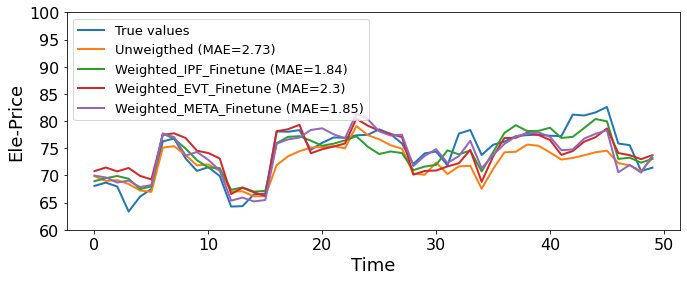

In [229]:
models = ['price_all.h5', 
          'price_all_weighted_IPF_95_ft.h5',
          'price_all_weighted_EVT_95_ft.h5', 
          'price_all_weighted_META_95_ft.h5'
         ]

labels = ['Unweigthed', 
          'Weighted_IPF_Finetune',
          'Weighted_EVT_Finetune', 
          'Weighted_META_Finetune'
         ]

plt.figure(figsize=(11, 4))
sample_id = 90
LINEWIDTH = 2
TICKSIZE = 16
FONTSIE = 18
LEGEND = 13

for i in range(len(models)):
    model_path = '../saved_models_mlp/' + models[i]
    #print('model:', model_path)
    saved_model = load_model(model_path) 
    yhat_extreme = saved_model.predict(test_X_extreme)
    inv_yhat_extreme = scaler.inverse_transform(yhat_extreme)
    inv_y_extreme = scaler.inverse_transform(test_y_extreme)


    #print(inv_yhat_extreme.shape, inv_y_extreme.shape,  '\n')
    sample_inv_yhat_extreme = inv_yhat_extreme[:50, 0]
    sample_inv_y_extreme = inv_y_extreme[:50, 0]
#     sample_inv_yhat_extreme = inv_yhat_extreme[sample_id, :]
#     sample_inv_y_extreme = inv_y_extreme[sample_id, :]

    
    if i == 0:
        plt.plot(sample_inv_y_extreme, linewidth=LINEWIDTH, label='True values')
    plt.plot(sample_inv_yhat_extreme, linewidth=LINEWIDTH, label=labels[i]+' (MAE={})'.format(float("{:.2f}".format(mae(sample_inv_yhat_extreme,sample_inv_y_extreme)))))
    plt.xticks(fontsize=TICKSIZE)
    plt.yticks(fontsize=TICKSIZE)
    plt.xlabel('Time', fontsize=FONTSIE)
    plt.ylabel('Ele-Price', fontsize=FONTSIE)
    plt.ylim(60, 100)
    plt.legend(fontsize=LEGEND, loc='best')
    plt.savefig('figures/price_vis.jpg', bbox_inches='tight')
#     plt.show()

### Electricity load

In [230]:
dataset = pd.read_csv('../data/energy_weather.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
# data


values = data.values
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 4
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


train_X_pm = train_X[:, 0, feature_idx]
val_X_pm = val_X[:, 0, feature_idx]
test_X_pm = test_X[:, 0, feature_idx]


percentile = 95
merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))
percentile_pm = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)


test_X_extreme = test_X[test_X_pm > percentile_pm]
test_y_extreme = test_y[test_X_pm > percentile_pm]

test_X_normal = test_X[test_X_pm <= percentile_pm]
test_y_normal = test_y[test_X_pm <= percentile_pm]

95th Percentile of Daily Rain: 0.793594933402977


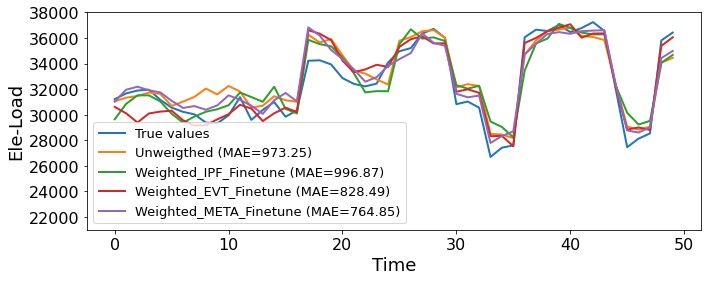

In [231]:
models = ['load_all.h5', 
          'load_all_weighted_IPF_95_ft.h5',
          'load_all_weighted_EVT_95_ft.h5', 
          'load_all_weighted_META_95_ft.h5'
         ]

labels = ['Unweigthed', 
          'Weighted_IPF_Finetune',
          'Weighted_EVT_Finetune', 
          'Weighted_META_Finetune'
         ]

plt.figure(figsize=(11, 4))
sample_id = 90
LINEWIDTH = 2
TICKSIZE = 16
FONTSIE = 18
LEGEND = 13

for i in range(len(models)):
    model_path = '../saved_models_mlp/' + models[i]
    #print('model:', model_path)
    saved_model = load_model(model_path) 
    yhat_extreme = saved_model.predict(test_X_extreme)
    inv_yhat_extreme = scaler.inverse_transform(yhat_extreme)
    inv_y_extreme = scaler.inverse_transform(test_y_extreme)


    #print(inv_yhat_extreme.shape, inv_y_extreme.shape,  '\n')
    sample_inv_yhat_extreme = inv_yhat_extreme[40:90, 0]
    sample_inv_y_extreme = inv_y_extreme[40:90, 0]
#     sample_inv_yhat_extreme = inv_yhat_extreme[sample_id, :]
#     sample_inv_y_extreme = inv_y_extreme[sample_id, :]

    
    if i == 0:
        plt.plot(sample_inv_y_extreme, linewidth=LINEWIDTH, label='True values')
    plt.plot(sample_inv_yhat_extreme, linewidth=LINEWIDTH, label=labels[i]+' (MAE={})'.format(float("{:.2f}".format(mae(sample_inv_yhat_extreme,sample_inv_y_extreme)))))
    plt.xticks(fontsize=TICKSIZE)
    plt.yticks(fontsize=TICKSIZE)
    plt.xlabel('Time', fontsize=FONTSIE)
    plt.ylabel('Ele-Load', fontsize=FONTSIE)
    plt.ylim(21000, 38000)
    plt.legend(fontsize=LEGEND, loc='best')
    plt.savefig('figures/load_vis.jpg', bbox_inches='tight')
#     plt.show()

### Pressure

In [232]:
data = pd.read_csv("../data/jena_climate_2009_2016_hourly.csv", index_col=0)
data.fillna(0, inplace=True)


values = data.values
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 5
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


train_X_pm = train_X[:, 0, feature_idx]
val_X_pm = val_X[:, 0, feature_idx]
test_X_pm = test_X[:, 0, feature_idx]


percentile = 95
merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))
percentile_pm = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)


test_X_extreme = test_X[test_X_pm > percentile_pm]
test_y_extreme = test_y[test_X_pm > percentile_pm]

test_X_normal = test_X[test_X_pm <= percentile_pm]
test_y_normal = test_y[test_X_pm <= percentile_pm]

95th Percentile of Daily Rain: 0.48441203148316114


(811, 12) (811, 12) 

(811, 12) (811, 12) 

(811, 12) (811, 12) 

(811, 12) (811, 12) 



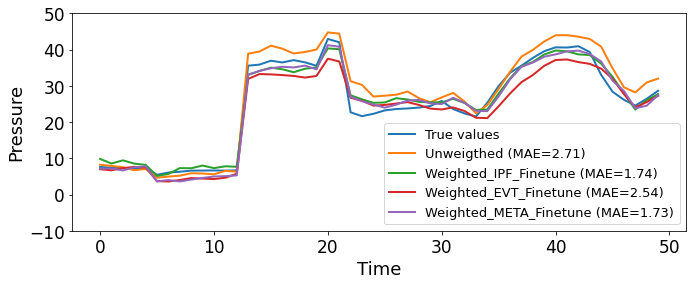

In [233]:
models = ['pressure_all.h5', 
          'pressure_all_weighted_IPF_95_ft.h5',
          'pressure_all_weighted_EVT_95_ft.h5', 
          'pressure_all_weighted_META_95_ft.h5'
         ]

labels = ['Unweigthed', 
          'Weighted_IPF_Finetune',
          'Weighted_EVT_Finetune', 
          'Weighted_META_Finetune'
         ]

plt.figure(figsize=(11, 4))
sample_id = 80
LINEWIDTH = 2
TICKSIZE = 17
FONTSIE = 18
LEGEND = 13

for i in range(len(models)):
    model_path = '../saved_models_mlp/' + models[i]
    #print('model:', model_path)
    saved_model = load_model(model_path) 
    yhat_extreme = saved_model.predict(test_X_extreme)
    inv_yhat_extreme = scaler.inverse_transform(yhat_extreme)
    inv_y_extreme = scaler.inverse_transform(test_y_extreme)


    print(inv_yhat_extreme.shape, inv_y_extreme.shape,  '\n')
    sample_inv_yhat_extreme = inv_yhat_extreme[310:360, 0]
    sample_inv_y_extreme = inv_y_extreme[310:360, 0]
#     sample_inv_yhat_extreme = inv_yhat_extreme[sample_id, :]
#     sample_inv_y_extreme = inv_y_extreme[sample_id, :]

    
    if i == 0:
        plt.plot(sample_inv_y_extreme, linewidth=LINEWIDTH, label='True values')
    plt.plot(sample_inv_yhat_extreme, linewidth=LINEWIDTH, label=labels[i]+' (MAE={})'.format(float("{:.2f}".format(mae(sample_inv_yhat_extreme,sample_inv_y_extreme)))))
    plt.xticks(fontsize=TICKSIZE)
    plt.yticks(fontsize=TICKSIZE)
    plt.xlabel('Time', fontsize=FONTSIE)
    plt.ylabel('Pressure', fontsize=FONTSIE)
    plt.ylim(-10, 50)
    plt.legend(fontsize=LEGEND, loc='best')
    plt.savefig('figures/pressue_vis.jpg', bbox_inches='tight')
#     plt.show()

### PM25

In [234]:
data = pd.read_csv("../data/pollution.csv", index_col=0)
data.fillna(0, inplace=True)

values = data.values
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


train_X_pm = train_X[:, 0, feature_idx]
val_X_pm = val_X[:, 0, feature_idx]
test_X_pm = test_X[:, 0, feature_idx]


percentile = 95
merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))
percentile_pm = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)




test_X_extreme = test_X[test_X_pm > percentile_pm]
test_y_extreme = test_y[test_X_pm > percentile_pm]

test_X_normal = test_X[test_X_pm <= percentile_pm]
test_y_normal = test_y[test_X_pm <= percentile_pm]

95th Percentile of Daily Rain: 0.33400402414486924


model: ../saved_models_mlp/pm_all.h5
(581, 12) (581, 12) 

model: ../saved_models_mlp/pm_all_weighted_IPF_95_ft.h5
(581, 12) (581, 12) 

model: ../saved_models_mlp/pm_all_weighted_EVT_95_ft.h5
(581, 12) (581, 12) 

model: ../saved_models_mlp/pm_all_weighted_META_95_ft.h5
(581, 12) (581, 12) 



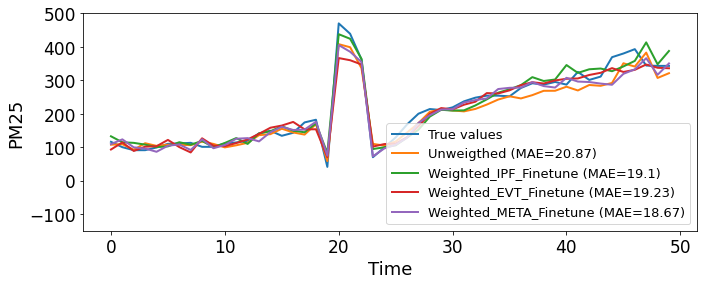

In [235]:
models = ['pm_all.h5', 
          'pm_all_weighted_IPF_95_ft.h5',
          'pm_all_weighted_EVT_95_ft.h5', 
          'pm_all_weighted_META_95_ft.h5'
         ]

labels = ['Unweigthed', 
          'Weighted_IPF_Finetune',
          'Weighted_EVT_Finetune', 
          'Weighted_META_Finetune'
         ]

plt.figure(figsize=(11, 4))
sample_id = 70
LINEWIDTH = 2
TICKSIZE = 17
FONTSIE = 18
LEGEND = 13

for i in range(len(models)):
    model_path = '../saved_models_mlp/' + models[i]
    print('model:', model_path)
    saved_model = load_model(model_path) 
    yhat_extreme = saved_model.predict(test_X_extreme)
    inv_yhat_extreme = scaler.inverse_transform(yhat_extreme)
    inv_y_extreme = scaler.inverse_transform(test_y_extreme)


    print(inv_yhat_extreme.shape, inv_y_extreme.shape,  '\n')
    sample_inv_yhat_extreme = inv_yhat_extreme[410:460, 0]
    sample_inv_y_extreme = inv_y_extreme[410:460, 0]
#     sample_inv_yhat_extreme = inv_yhat_extreme[sample_id, :]
#     sample_inv_y_extreme = inv_y_extreme[sample_id, :]

    
    if i == 0:
        plt.plot(sample_inv_y_extreme, linewidth=LINEWIDTH, label='True values')
    plt.plot(sample_inv_yhat_extreme, linewidth=LINEWIDTH, label=labels[i]+' (MAE={})'.format(float("{:.2f}".format(mae(sample_inv_yhat_extreme,sample_inv_y_extreme)))))
    plt.xticks(fontsize=TICKSIZE)
    plt.yticks(fontsize=TICKSIZE)
    plt.xlabel('Time', fontsize=FONTSIE)
    plt.ylabel('PM25', fontsize=FONTSIE)
    plt.ylim(-150, 500)
    plt.legend(fontsize=LEGEND, loc='best')
    plt.savefig('figures/pm_vis.jpg', bbox_inches='tight')
#     plt.show()